## Melanoma image classification


Melanoma, also known as malignant melanoma, is a type of skin cancer that develops from the pigment-producing cells known as melanocytes

The primary cause of melanoma is ultraviolet light (UV) exposure in those with low levels of the skin pigment melanin. The UV light may be from the sun or other sources, such as tanning devices. Those with many moles, a history of affected family members and poor immune function are at greater risk. A number of rare genetic conditions such as xeroderma pigmentosum also increase the risk. Diagnosis is by biopsy and analysis of any skin lesion that has signs of being potentially cancerous.

Using sunscreen and avoiding UV light may prevent melanoma. Treatment is typically removal by surgery In those with slightly larger cancers, nearby lymph nodes may be tested for spread (metastasis). Most people are cured if spread has not occurred. For those in whom melanoma has spread, immunotherapy, biologic therapy, radiation therapy or chemotherapy may improve survival.With treatment, the five-year survival rates in the United States are 99% among those with localized disease, 65% when the disease has spread to lymph nodes and 25% among those with distant spread.The likelihood that melanoma will reoccur or spread depends on its thickness, how fast the cells are dividing and whether or not the overlying skin has broken down.

Melanoma is the most dangerous type of skin cancer. Globally, in 2012, it newly occurred in 232,000 people. In 2015, there were 3.1 million people with active disease, which resulted in 59,800 deaths. Australia and New Zealand have the highest rates of melanoma in the world. There are also high rates in Northern Europe and North America, while it is less common in Asia, Africa and Latin America. In the United States melanoma occurs about 1.6 times more often in men than women.Melanoma has become more common since the 1960s in areas mostly populated by people of European descent.


In this competition given an image of the potential cancer we are asked to predict whether it's beingn or malignant.



In [ ]:
!pip install livelossplot

# Imports

In [ ]:
import tensorflow
import numpy as np 
import pandas as pd 
import cv2
import PIL
from IPython.display import Image, display
from keras.applications.vgg16 import VGG16,preprocess_input
import plotly.graph_objs as go
import plotly.graph_objects as go
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model,load_model
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten,BatchNormalization,Activation
from keras.layers import GlobalMaxPooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
import skimage.io
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.keras import backend as keras
from livelossplot import PlotLossesKeras

In [ ]:
def focal_loss(alpha=0.3,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = keras.binary_crossentropy(y_true, y_pred)
        
        y_pred = keras.clip(y_pred, keras.epsilon(), 1.- keras.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = keras.pow((1-p_t), gamma)

        # compute the final loss and return
        return keras.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

# Get Train & Test data

In [ ]:
train_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
test_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'
train=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
test=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')
submission=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')

# Data examination

1. Medical data in most of the cases is unbalanced 
2. Can we use other features ( Age? ) instead of just images

In [ ]:
train.head(10)

# Data explained :

Image name – name of image to use 
patient_id - patient_id (I’m not sure the feature is useful ) 
age_approx , sex – might be useful to improve accuracy in parallel to CNN model 

anatom_site_general_challenge –  location of the skin cancer given in the image
Diagnosis – type of potential cancer (unknow , nevus , melanoma , etc…) 
benign_malignant – flag for benign='benign' or malignant='malignant'
target – benign=0 or malignant=1







In [ ]:
train.isnull().sum()

We can see  missing data - nonetheless for image classification this wouldn't impact the results(0 missing in target & image_name)

In [ ]:
train['diagnosis'].value_counts()

In [ ]:
unbalance_set=train['target'].value_counts()
print(unbalance_set)
print("Malignant cases : " + str((unbalance_set[1]/(unbalance_set[0]+unbalance_set[1]))*100) + " %")


Only ~1.8% patients in our data have malignant cancer



In [ ]:
labels=train['anatom_site_general_challenge'].value_counts().index
values=train['anatom_site_general_challenge'].value_counts().values*100/train['anatom_site_general_challenge'].shape[0]
plt.bar(labels,values)
plt.rcParams["figure.figsize"] = (10,10)
plt.title('anatom_site_general_challenge')
plt.ylabel('percentage %')




more than 50% is on torso .


Let's look at the diagnosis provided by Dermatologists - "unknown" was removed

In [ ]:
labels=train['diagnosis'].value_counts().index[1:]
values=train['diagnosis'].value_counts().values[1:]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent',
                             insidetextorientation='radial'
                            )])
fig.show()


Now let’s use other features(i.e not image) to see if we get a glance to the expected model – i.e sex impact melanoma? Maybe age impact melanoma ,etc…

In [ ]:
pd.crosstab(train['diagnosis'].values,train['benign_malignant'])

In [ ]:
pd.crosstab(train['sex'].values,train['benign_malignant'])

In [ ]:
pd.crosstab(train['anatom_site_general_challenge'].values,train['benign_malignant'])

In [ ]:
pd.crosstab(train['age_approx'].values,train['benign_malignant'])

From initial glance it’s hard to see any relevant correlation here
Othar than all patients diagnosed as "melanoma" have malignant cancers -which is expected

To tackle Unbalanced dataset problem you should try to balance your dataset, either by over-sampling minority classes or under-sampling majority classes (or both). Arguably, a good choice would be SMOTE (Synthetic Minority Over-sampling Technique) algorithm, as mentioned above. Here you can find a comparison of different over-sampling algorithms. If you're a Python user, imbalanced-learn is a nice library that implements many useful techniques for balancing datasets.

On the other hand, if you're trying to classify images, a nice way to increase your dataset size is to augment it (i.e. by creating reasonable synthetic examples, e.g. similar images but rotated/shifted tiny bit with respect to original ones). You might sometimes find it useful to augment the minority classes to achieve better balance. Keras ImageDataGenerator class is a good tool for this purpose.

https://medium.com/x8-the-ai-community/solving-class-imbalance-problem-in-cnn-9c7a5231c478

In [ ]:
df_0=train[train['target']==0].sample(1000)
df_1=train[train['target']==1]
train=pd.concat([df_0,df_1])
train=train.reset_index()

Before going any further with training let's take a look at sample photos from both classes.

In [ ]:
print('Benign Cases')
benign=[]
df_benign=df_0.sample(40)
df_benign=df_benign.reset_index()
for i in range(40):
    img=cv2.imread(str(train_dir + df_benign['image_name'].iloc[i]+'.jpg'))
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    benign.append(img)
f, ax = plt.subplots(5,8, figsize=(10,8))
for i, img in enumerate(benign):
        ax[i//8, i%8].imshow(img)
        ax[i//8, i%8].axis('off')
        
plt.show()

In [ ]:
print('Malignant Cases')
malignant=[]
df_malignant=df_1.sample(40)
df_malignant=df_malignant.reset_index()
for i in range(40):
    img=cv2.imread(str(train_dir + df_malignant['image_name'].iloc[i]+'.jpg'))
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    malignant.append(img)
f, ax = plt.subplots(5,8, figsize=(10,8))
for i, img in enumerate(malignant):
        ax[i//8, i%8].imshow(img)
        ax[i//8, i%8].axis('off')
        
plt.show()

## Preparing the Datasets

In [ ]:
labels=[]
data=[]
for i in range(train.shape[0]):
    data.append(train_dir + train['image_name'].iloc[i]+'.jpg')
    labels.append(train['target'].iloc[i])
df=pd.DataFrame(data)
df.columns=['images']
df['target']=labels

In [ ]:
test_data=[]
for i in range(test.shape[0]):
    test_data.append(test_dir + test['image_name'].iloc[i]+'.jpg')
df_test=pd.DataFrame(test_data)
df_test.columns=['images']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df['images'],df['target'], test_size=0.25, random_state=7)

train=pd.DataFrame(X_train)
train.columns=['images']
train['target']=y_train

validation=pd.DataFrame(X_val)
validation.columns=['images']
validation['target']=y_val

# Parameters 

In [ ]:
width  =224
height =224
batch_size=8
filters = 3
nb_epochs = 5


In [ ]:
nb_train_steps = train.shape[0]//batch_size
nb_val_steps=validation.shape[0]//batch_size
print("Number of training and validation steps: {} and {}".format(nb_train_steps,nb_val_steps))

I'll do some very basic preprocessing like 
* normalizing
* reshaping
* augmentation(only for tarin data)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,horizontal_flip=True)
val_datagen=ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='images',
    y_col='target',
    target_size=(height, width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='raw')

validation_generator = val_datagen.flow_from_dataframe(
    validation,
    x_col='images',
    y_col='target',
    target_size=(height, width),
    shuffle=False,
    batch_size=batch_size,
    class_mode='raw')



# Model 
Let’s take to start with pretrained RESNET50 with extra dense output layer 
The competition is evaluated on AUC scores which will be our metric


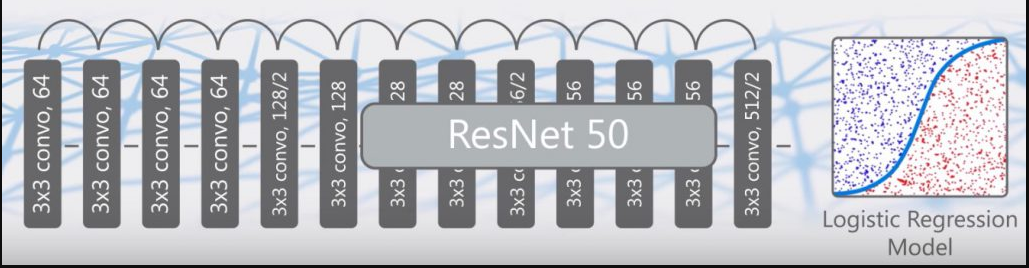

In [ ]:
def resnet_model( num_classes=None):

    model = ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, filters)) #VGG16
    x=Flatten()(model.output)
    output=Dense(1,activation='sigmoid')(x) # because we have to predict the AUC
    model=Model(model.input,output)
    
    return model

resnet_conv=resnet_model(1)

* Also, because of class imbalance it's better to use **focal loss** rather than normal **binary_crossentropy**.You can read more about it [here](https://arxiv.org/abs/1708.02002)

FAIR proposes a new loss function that focuses a neural networks attention on the instances where it predicted the wrong class. Instead of trying to reduce outliers or predictions where the model’s prediction is far off from the truth, Focal Loss reduces the weight (or impact) the values it predicted correctly carry. The loss function is just a mathematical way of saying how far off a guess is from the real value of a datapoint. Frequently used in computer vision is the Cross Entropy Loss, which the Focal loss adds probability-dependent weight to CE loss.



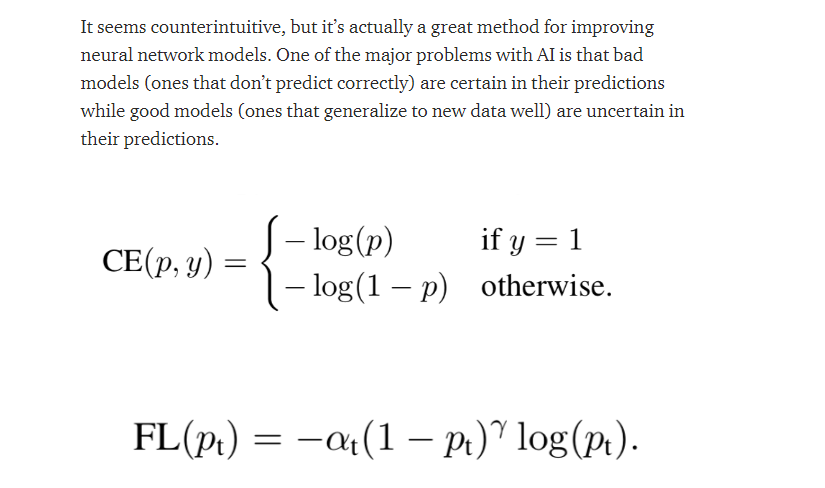

In [ ]:
opt = Adam(lr=1e-4)
resnet_conv.compile(loss=focal_loss(), metrics=[tf.keras.metrics.AUC()],optimizer=opt)

In [ ]:
cb=[PlotLossesKeras()]
resnet_conv.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_steps,
    epochs=nb_epochs,
    validation_data=validation_generator,
    callbacks=cb,
    validation_steps=nb_val_steps)